<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/4_2SMILEVAEPropertyVAE_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Installs and Imports**

In [1]:
!pip install tensorflow==1.12
!pip install keras==2.2.4
!pip install h5py

     |████████████████████████████████| 83.1MB 60kB/s 
     |████████████████████████████████| 3.1MB 55.9MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 317kB 8.4MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


--2020-11-25 12:10:43--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-11-25 12:10:43--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   224MB/s    in 0.4s    

2020-11-25 12:10:43 (224 MB/s) - ‘Minicon

In [3]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re

# FOR VAE Architecture 
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
import keras
from keras import layers
import tensorflow as tf
from keras.models import load_model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [4]:
import rdkit
print("RDKit: %s"%rdkit.__version__)
print("Keras: %s"%keras.__version__)

RDKit: 2020.09.1
Keras: 2.2.4


# **Data Fetching**

In [6]:
WEIGHTS_FOLDER = 'sample_data/weights/'
smifile = "sample_data/SMILEWithProp.csv"
data = pd.read_csv(smifile, delimiter = ",", header='infer')
NUM_SMILES = len(data)
data.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [7]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data, test_size=0.2, shuffle=False)
print(smiles_train.shape)
print(smiles_test.shape)
print(NUM_SMILES)

(1207, 4)
(302, 4)
1509


In [8]:
logP_train = smiles_train['logP']
logP_test = smiles_test['logP']

qed_train=smiles_train['qed']
qed_test=smiles_test['qed']

SAS_train=smiles_train['SAS']
SAS_test=smiles_test['SAS']

train=np.array([logP_train, qed_train, SAS_train])
test= np.array([logP_test, qed_test, SAS_test])
y_train_property=train.transpose()
y_test_property=test.transpose()

In [9]:
#Labels for the Smiles String. We will deal with three properties values.
print(type(y_train_property))
print(type(y_test_property))
print(y_train_property.shape)
print(y_test_property.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1207, 3)
(302, 3)


### **Vector Representation of Data**

In [10]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
# print(char_to_int)
print(len(charset), embed)
# print(embed)

40 108


In [11]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train['smiles'].values)
X_test = vectorize(smiles_test['smiles'].values)

(1207, 108, 40)
(302, 108, 40)


### **Checking if Vectorization works!!**

Cc1ccc(NC(=S)NC(C)C)cc1C



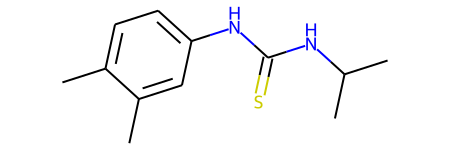

In [12]:
idx=281
print(smiles_train['smiles'][idx])
from rdkit.Chem.Draw import IPythonConsole
m = Chem.MolFromSmiles(smiles_train['smiles'][idx])
m

25
Cc1ccc(NC(=S)NC(C)C)cc1C



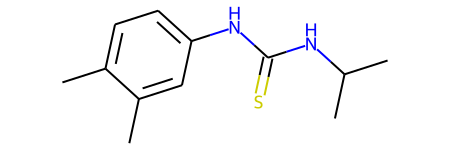

In [13]:
# Going back from vectorized form back to a readable string
strr="".join([int_to_char[idx] for idx in np.argmax(X_train[idx,:,:], axis=1)])
# String After Tructation of extra symbols
line = re.sub('[!E]', '', strr)
print(len(line))
print(line)
m = Chem.MolFromSmiles(line)
m

In [14]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
# print(mol_size_x)
# print(mol_size_y)
print(orig_dim)
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
# print(type(X_train))
# print(X_train.shape)
# print(X_train.shape[1])

4320


# **VAE with Predictor**

In [15]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=5
Z_DIM=20 # Dimension of the latent vector (z)
epochs=50
pre_trained=False

### **Encoder**

In [16]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu', name='hidden')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer in the model
  encoder_output = Lambda(sampling, output_shape=(2,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output, name='encoder')



### **Decoder**

In [17]:
# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu', name='hidden')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid', name='decoder_lastlayer')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output, name='decoder')




### **Predictor**

In [18]:
def create_predictor_linear():
    '''
    Creates a regressor that estimates property values 
    from latent variables.
    '''
    predictor_input = layers.Input(shape=(Z_DIM,), name='predictor_input', dtype='float32')
    
    x = layers.Dense(10, activation='relu', name='hidden')(predictor_input)
    x = layers.Dense(3, activation='linear', name='predictor_lastlayer', dtype='float32')(x)
    return Model(predictor_input, x, name='predictor')


### **Creating the OverAll Model**

In [19]:
# Model Creation 
def create_model():

  #Creating Encoder
  vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,                                                                                         output_dim = Z_DIM)
# vae_encoder.summary()
  
  
  #Creating Decoder
  vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
# vae_decoder.summary()

  #Creating the Predictor
  predictor = create_predictor_linear()
  t_predicted = predictor(mean_mu)
  


  #Creating the VAE Model 
  vae_input = vae_encoder_input

  # Output will be the output of the decoder. The term - decoder(encoder_output) 
  vae_output = vae_decoder(vae_encoder_output)

  # VAE Model with Predictor
  vae_predictor = Model(vae_input, [vae_output,t_predicted], name='VAE with Predictor')

  return vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder, vae_decoder_input, vae_decoder_output, vae_decoder,predictor, vae_input, vae_output, vae_predictor

#Creating the overall Model
encoder_input, encoder_output,  mean_mu, log_var, encoder, decoder_input, decoder_output, decoder, predictor, vae_input, vae_output, vae_predictor = create_model()



### **VAE Loss Function**

In [20]:
#VAE Loss Function
def vae_loss(vae_input, vae_output):
  reconstruction_loss = binary_crossentropy(vae_input, vae_output)
  reconstruction_loss = reconstruction_loss * orig_dim
    
  kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
  kl_loss = K.sum(kl_loss, axis=-1)    
  kl_loss = kl_loss * -0.5
    
  vae_loss_val = K.mean(reconstruction_loss + kl_loss)
  return vae_loss_val


**Plotting all models**

In [21]:
# Plot the VAE-Predictor Model
plot_model(vae_predictor, to_file='smilesvae_predictor.png', show_shapes=True, show_layer_names=True)   #, expand_nested=False


# Plot the Encoder Model
plot_model(encoder, to_file='only_encoder.png', show_shapes=True, show_layer_names=True)  #, expand_nested=True

# Plot the Decoder Model
plot_model(decoder, to_file='only_decoder.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

#Plot the Predictor Model
plot_model(predictor, to_file='only_predictor.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# plot_model(vae_model, to_file='smilesvae_model.png', show_shapes=True, show_layer_names=True)   #, expand_nested=False

**Checkpoint**

In [22]:
# Creating Model Checkpoint for training...

checkpoint_path = "sample_data/train_ckpt/cp.ckpt"
new_check_path='VAE_Predictor{epoch:02d}.h5'            #'VAE_Predictor{epoch:02d}.h5'
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=new_check_path, verbose=1, save_weights_only=False, save_best_only=True)   #, save_freq=5

# Loading weights from the latest checkpoints
#get the latest checkpoint file
checkpoint_dir = os.path.dirname(new_check_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

### **Training or Loading the VAE-Predictor Model**

In [62]:
pre_trained=True
epochs=200
if __name__ == '__main__':          
#     Train the Variational AutoEncoder
    if pre_trained==False:
      vae_predictor.compile(optimizer='adam', 
                      loss=[vae_loss, 'mean_squared_error'], 
                      loss_weights=[1.0, 0.5]     
                      ) 
      history = vae_predictor.fit(x=X_train,
                            y=[X_train,y_train_property], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test, y_test_property]),
                            verbose=2,
                            callbacks=[cp_callback] )   
      vae_predictor.save(new_check_path)
    else:
      vae_predictor.load_weights(new_check_path)
      history = vae_predictor.fit(x=X_train,
                            y=[X_train,y_train_property], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test, y_test_property]),
                            verbose=2,
                            callbacks=[cp_callback]) 
      vae_predictor.save(new_check_path)
    

Train on 1207 samples, validate on 302 samples
Epoch 1/200
 - 3s - loss: 30.4047 - decoder_loss: 30.2725 - predictor_loss: 0.2645 - val_loss: 34.1481 - val_decoder_loss: 33.9550 - val_predictor_loss: 0.3861

Epoch 00001: val_loss did not improve from 33.58383
Epoch 2/200
 - 3s - loss: 30.4771 - decoder_loss: 30.3435 - predictor_loss: 0.2672 - val_loss: 33.8344 - val_decoder_loss: 33.6476 - val_predictor_loss: 0.3736

Epoch 00002: val_loss did not improve from 33.58383
Epoch 3/200
 - 3s - loss: 30.5572 - decoder_loss: 30.4229 - predictor_loss: 0.2687 - val_loss: 33.8133 - val_decoder_loss: 33.6226 - val_predictor_loss: 0.3814

Epoch 00003: val_loss did not improve from 33.58383
Epoch 4/200
 - 3s - loss: 30.5972 - decoder_loss: 30.4655 - predictor_loss: 0.2636 - val_loss: 34.4787 - val_decoder_loss: 34.2859 - val_predictor_loss: 0.3856

Epoch 00004: val_loss did not improve from 33.58383
Epoch 5/200
 - 3s - loss: 30.4540 - decoder_loss: 30.3204 - predictor_loss: 0.2672 - val_loss: 34.474

In [24]:
# vae_predictor.save('my_model.h5')
# vae_predictor.save(checkpoint_path)



In [25]:
# new_model = tf.keras.models.load_model('my_model.h5')
# history = new_model.fit(x_train[:2000], y_train[:2000],
#               batch_size=BATCH_SIZE,
#               epochs=6,
#               validation_data=(x_val[:100], y_val[:100]),
#               shuffle=True)


# **Latent Space Visualization**

### **Each Component of latent space**

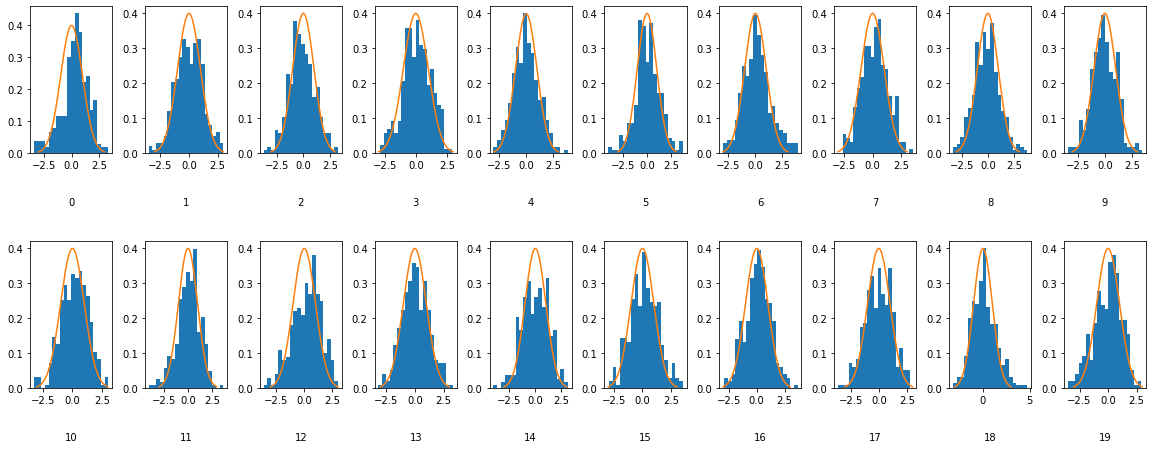

In [26]:
from scipy.stats import norm
# with graph.as_default():   # We are using this statement to reuse the last saved trained model
z_test = encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(20):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### **logP Properties**

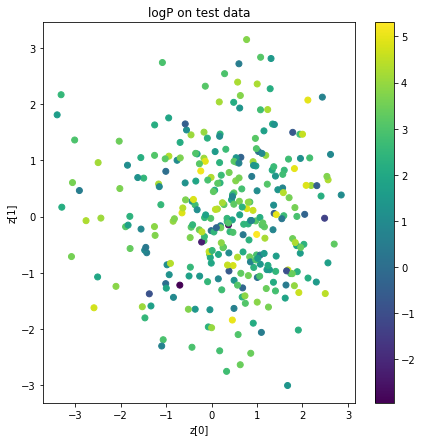

In [27]:
from sklearn.manifold import TSNE
z_mean = encoder.predict(X_test)
# print(z_mean)
model_name='VAESMILES_Latent'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "smilesvae_mean.png")

# z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=logP_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('logP on test data')
plt.savefig(filename)
plt.show()

### **qed Properties**

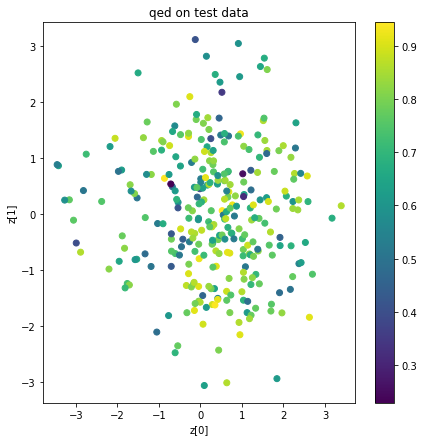

In [28]:
from sklearn.manifold import TSNE
z_mean = encoder.predict(X_test)
# print(z_mean)
model_name='VAESMILES_Latent'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "smilesvae_mean.png")

# z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=qed_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('qed on test data')
plt.savefig(filename)
plt.show()

### **SAS Properties**

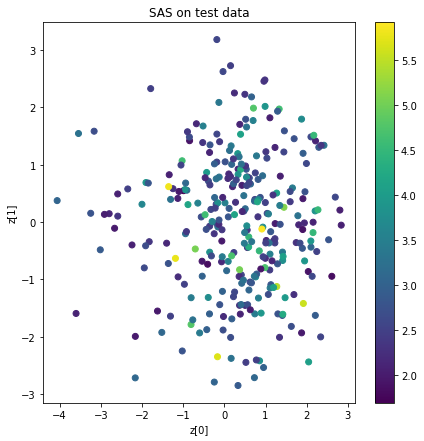

In [29]:
from sklearn.manifold import TSNE
z_mean = encoder.predict(X_test)
# print(z_mean)
model_name='VAESMILES_Latent'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "smilesvae_mean.png")

# z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=SAS_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('SAS on test data')
plt.savefig(filename)
plt.show()

# **Reconstruction**


In [30]:
# Calculating mean and standard deviation of all property values on test data

logp_mean_test, qed_mean_test,SAS_mean_test= np.mean(y_test_property, axis=0)
logp_std_test, qed_std_test,SAS_std_test = np.std(y_test_property, axis=0)


In [31]:
# encoded, decoded and predicted data on test dataset

encoded_xtest=encoder.predict(X_test)
predicted_xtest=predictor.predict(encoded_xtest)
decoded_xtest=decoder.predict(encoded_xtest)
print(encoded_xtest.shape)
print(predicted_xtest.shape)
print(decoded_xtest.shape)


(302, 20)
(302, 3)
(302, 4320)


In [32]:
# Reshaping the original and reconstructed test data
orig_test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
reconst_test = decoded_xtest.reshape(len(X_test), mol_size_x,mol_size_y)
print(orig_test.shape)
print(reconst_test.shape)

(302, 108, 40)
(302, 108, 40)


### **Reconstruction and Prediction on Original test data set**

[2.8965893  0.28726587 2.2456582 ]
!C[C@H]1CN(CC(=O)Nc2nc(-c3ccccc3Cl)cs2)CCO1
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
108
C[C@H]1CN(CC(=O)Nc2nc(-c3ccccc3Cl)cs2)CCO1

43


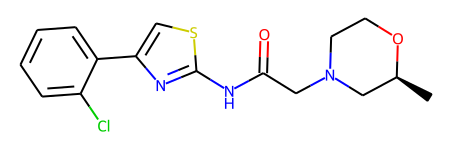

In [70]:
# Going back from vectorized form back to a readable string on original test data

# Prediction 
idx=150
print(predicted_xtest[idx])

#Reconstruction

mol="".join([int_to_char[idx] for idx in np.argmax(orig_test[idx,:,:], axis=1)])
print(mol)
print(len(mol))
mol = re.sub('!|E',"", mol)
print(mol)
print(len(mol))
m = Chem.MolFromSmiles(mol)
m

### **Reconstruction and Prediction of property on reconstructed test data**

In [68]:
# Going back from vectorized form back to a readable string on original test data

# Prediction 
print(predicted_xtest[idx])

#Reconstruction
mol="".join([int_to_char[idx] for idx in np.argmax(reconst_test[idx,:,:], axis=1)])
print(mol)
print(len(mol))
mol = re.sub('!|E',"", mol)
print(mol)
print(len(mol))
m = Chem.MolFromSmiles(mol)
m

[2.7067468 1.0106442 4.0982614]
!COc1cccOC)cc([[@H+](CC[@@H]CCCC=CO(c2cccc)C)c2)C)c

EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
108
COc1cccOC)cc([[@H+](CC[@@H]CCCC=CO(c2cccc)C)c2)C)c


52


RDKit ERROR: [13:24:18] SMILES Parse Error: extra close parentheses while parsing: COc1cccOC)cc([[@H+](CC[@@H]CCCC=CO(c2cccc)C)c2)C)c
RDKit ERROR: 
RDKit ERROR: 
RDKit ERROR: [13:24:18] SMILES Parse Error: Failed parsing SMILES 'COc1cccOC)cc([[@H+](CC[@@H]CCCC=CO(c2cccc)C)c2)C)c
RDKit ERROR: 
RDKit ERROR: ' for input: 'COc1cccOC)cc([[@H+](CC[@@H]CCCC=CO(c2cccc)C)c2)C)c
RDKit ERROR: 
RDKit ERROR: '


# **Generating New Samples from Normal Distribution**

In [69]:
prop_val={}
m=None
n_mol=10
i=0
latent_samples= np.random.normal(0,1,size=(n_mol,Z_DIM))
# print(latent_samples.shape)
predicted_prop_samples=predictor.predict(latent_samples)
# print(predicted_prop_samples.shape)
print("mean of all properties on test data")
print(logp_mean_test, qed_mean_test,SAS_mean_test)
print("satndard deviation of all properties on test data")
print(logp_std_test, qed_std_test,SAS_std_test)

#Checking the property of molecule
for id, latent_mol in enumerate(latent_samples):
  a=predicted_prop_samples[id][0]<(logp_mean_test+logp_std_test)
  b=predicted_prop_samples[id][0]>=(logp_mean_test-logp_std_test)
  c=predicted_prop_samples[id][1]<(qed_mean_test+qed_std_test)
  d=predicted_prop_samples[id][1]>=(qed_mean_test-qed_std_test)
  e=predicted_prop_samples[id][2]<(SAS_mean_test+SAS_std_test)
  f=predicted_prop_samples[id][2]>=(SAS_mean_test-SAS_std_test)
  if ((a & b) & (c & d) & (e & f)):  #Checking if all of the property values matches
    prop_val[i]=1
    print("Mol {}, Property Validated".format(id+1))
    print("Predicted Properties=")
    print(predicted_prop_samples[id][0], predicted_prop_samples[id][1], predicted_prop_samples[id][2])

    #Passing it to Decoder Now
    reconst_sample = decoder.predict(latent_samples[id:id+1])
    new_mol=reconst_sample.reshape(mol_size_x, mol_size_y) 
    mol="".join([int_to_char[idx] for idx in np.argmax(new_mol[:,:], axis=1)])
    mol = re.sub('!|E',"", mol)
    m = Chem.MolFromSmiles(mol, sanitize=True)
    if m is None:
      print('Mol {} {}, invalid SMILES'.format(id+1,m))
      continue                   
    else:
      try:
        m = Chem.SanitizeMol(m)
        print(m)
      except:
        print('Mol {}, invalid chemistry'.format(id+1)) 
    m
  else:    #No decoding happens here
    prop_val[i]=0
    print("Mol {}, Property Invalidated".format(id+1))  

mean of all properties on test data
2.4771253642384106 0.7170151110408212 2.963516528736832
satndard deviation of all properties on test data
1.4639469841537798 0.14166403787323872 0.811183384998689
Mol 1, Property Invalidated
Mol 2, Property Validated
Predicted Properties=
1.9977878 0.7558948 3.133384
Mol 2 None, invalid SMILES
Mol 3, Property Validated
Predicted Properties=
1.8773962 0.7570058 2.8645325
Mol 3 None, invalid SMILES
Mol 4, Property Validated
Predicted Properties=
1.6899657 0.7680175 2.9008226
Mol 4 None, invalid SMILES
Mol 5, Property Validated
Predicted Properties=
2.5946624 0.718897 2.808948
Mol 5 None, invalid SMILES
Mol 6, Property Invalidated
Mol 7, Property Validated
Predicted Properties=
2.9883692 0.7981153 2.6087403
Mol 7 None, invalid SMILES
Mol 8, Property Validated
Predicted Properties=
2.174882 0.7117455 3.600708
Mol 8 None, invalid SMILES
Mol 9, Property Validated
Predicted Properties=
1.7784011 0.78228354 3.243527
Mol 9 None, invalid SMILES
Mol 10, Propert

RDKit ERROR: [13:24:20] SMILES Parse Error: syntax error while parsing: CC(C)[CCN1(1NC(@@)c1Cc[(O)CC=O)21ccccc2)cc
RDKit ERROR: 1C
RDKit ERROR: [13:24:20] SMILES Parse Error: Failed parsing SMILES 'CC(C)[CCN1(1NC(@@)c1Cc[(O)CC=O)21ccccc2)cc
RDKit ERROR: 1C' for input: 'CC(C)[CCN1(1NC(@@)c1Cc[(O)CC=O)21ccccc2)cc
RDKit ERROR: 1C'
RDKit ERROR: [13:24:20] SMILES Parse Error: syntax error while parsing: CCOc1(1Ccc(C(=O)NHc1ccc(ccCnCC)N)C1=C
RDKit ERROR: 2
RDKit ERROR: [13:24:20] SMILES Parse Error: Failed parsing SMILES 'CCOc1(1Ccc(C(=O)NHc1ccc(ccCnCC)N)C1=C
RDKit ERROR: 2' for input: 'CCOc1(1Ccc(C(=O)NHc1ccc(ccCnCC)N)C1=C
RDKit ERROR: 2'
RDKit ERROR: [13:24:20] SMILES Parse Error: syntax error while parsing: CCC@O)([C@cc1NCC(=O)Nc1CCC(CC)CCc
RDKit ERROR: 
RDKit ERROR: [13:24:20] SMILES Parse Error: Failed parsing SMILES 'CCC@O)([C@cc1NCC(=O)Nc1CCC(CC)CCc
RDKit ERROR: ' for input: 'CCC@O)([C@cc1NCC(=O)Nc1CCC(CC)CCc
RDKit ERROR: '
RDKit ERROR: [13:24:20] SMILES Parse Error: extra close paren